In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read Dataset
df_raw = pd.read_csv('vgames2.csv', index_col=0, na_values=['Unknown', 'Misc'])
num_df_before = df_raw.shape[0]

#refine Year
df_raw.loc[df_raw.Year<=22,'Year'] += 2000
df_raw.loc[df_raw.Year<=99,'Year'] += 1900

#refine Sales data
sales_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for col in sales_col:
  df_raw[col] = df_raw[col].str.replace('M','')
  df_raw[col] = [(
      ele.replace('K', '') if re.match('.*K', ele) else round(float(ele) * 1000, 3)
      ) for ele in df_raw[col]]

#re-define data type
df_raw = df_raw.sort_values(['Name', 'Platform']).reset_index(drop= True)
(df_raw.isna()).sum()

Name              0
Platform          0
Year            271
Genre          1784
Publisher       261
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
dtype: int64

In [3]:
def update_seperated(df_test:pd.DataFrame):
  df_ret = df_test[df_test['Name'].str.contains('\(.*(s|S)ale')].copy()
  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    x = name.find(r'(')
    if name[x-1] == ' ': x -= 1
    #if name[x:].find('\(.*(A|a)ll') == -1: df_ret.Sep = True
    df_ret.loc[i, 'Name'] = name[:x]
  
  return df_ret

def update_dupl_na(df_test, df_raw, col):
  def make_dupl(df):
    return df[df.duplicated(subset= 'Name', keep= False) == True].sort_values('Name')
    
  df_not_NA = make_dupl(df_raw).dropna(subset= [col])
  df_NA = make_dupl(df_test).loc[df_test[col].isna() == True,:].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    df_sub = df_not_NA.query(f'Name == "{name}"')
    if  df_sub.shape[0] > 0:
      df_NA.loc[i, col] = df_sub[col].iloc[0]

  return df_NA

def year_in_title(df):
  df_ret = df[df.Name.str.contains('\d{4}')].\
              loc[df.Year.isna() == True, :].copy()
  for i in df_ret.index:
    name = df.loc[i, 'Name']
    df_ret.loc[i, 'Year'] = int(name[-4:])

  return df_ret

def col_in_title(df_test, df_raw, col):
  df_ret = df_test[df_test[col].isna() == True].copy()
  col_unique = df_raw.dropna(subset = [col])[col].unique()

  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    for col_u in col_unique:
      if name.find(col_u) >= 0:
        df_ret.loc[i, col] = col_u
        break
  
  return df_ret

def col_in_series(df_test, df_raw, col):
  df_not_NA = df_raw.dropna(subset= [col])
  df_NA = df_test[df_test[col].isna() == True].copy()

  for name in df_NA.Name.unique():
    name_x = name
    x = name.find(':')
    if x > 0: name_x = name[:x]
    idx = df_NA[df_NA.Name.str.contains(name_x)]
    df_sub = df_not_NA[df_not_NA.Name.str.contains(name_x)]

    if df_sub[col].unique().shape[0] == 1:
      df_NA.loc[idx, col] = df_sub[col].iloc[0]

    return df_NA


def col_in_title_manual(df_test, df_raw, col, sub):
  df_not_NA = df_raw.dropna(subset= [col]).loc[df_raw.Name.str.contains(sub)]
  df_NA = df_test[df_test[col].isna() == True].copy()
  
  if df_not_NA.shape[0] > 0:
    df_NA.loc[df_raw.Name.str.contains(sub), col] = df_not_NA[col].iloc[0]
  
  return df_NA

def clue_year(df_test:pd.DataFrame, df_raw:pd.DataFrame):
  df_not_NA = df_raw.dropna(subset= ['Year'])
  df_NA = df_test[df_test.Year.isna() == True].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    idx = df_NA.query(f'Name == "{name}"').index
    min = np.min(df_not_NA.Year)
    max = np.max(df_not_NA.Year)
    
    publisher = df_NA.loc[i,'Publisher']
    if publisher in df_raw.Publisher.unique():
      raw_p = df_not_NA.query(f'Publisher == "{publisher}"').Year

      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    for j in idx:
      platform = df_NA.Platform.loc[j]
      raw_p = df_not_NA.query(f'Platform == "{platform}"').Year
      
      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    df_NA.loc[i, 'Year'] = np.mean([min, max]).round(0)

  return df_NA

In [21]:
df_raw.Genre.unique()

array(['Sports', 'Role-Playing', 'Action', 'Racing', 'Shooter', nan,
       'Adventure', 'Puzzle', 'Simulation', 'Platform', 'Strategy',
       'Fighting'], dtype=object)

In [4]:
#make EDA dataframe
df = df_raw.loc[df_raw.Name.str.contains('\(.*wrong') == False].copy()

#find if it is separated
df.update(update_seperated(df))
df_raw.update(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [5]:
#NA control
df.update(update_dupl_na(df, df_raw,'Year'))
df.update(update_dupl_na(df, df_raw,'Genre'))
df.update(update_dupl_na(df, df_raw,'Publisher'))

df.update(year_in_title(df))
df.update(col_in_title(df, df_raw, 'Genre'))
df.update(col_in_title(df, df_raw, 'Publisher'))

df.update(col_in_series(df, df_raw, 'Genre'))
df.update(col_in_series(df, df_raw, 'Publisher'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16596 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16596 non-null  object 
 1   Platform     16596 non-null  object 
 2   Year         16460 non-null  float64
 3   Genre        14867 non-null  object 
 4   Publisher    16420 non-null  object 
 5   NA_Sales     16596 non-null  object 
 6   EU_Sales     16596 non-null  object 
 7   JP_Sales     16596 non-null  object 
 8   Other_Sales  16596 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [15]:
#NA control manually
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Dance ?Dance'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Pokemon .*/Pokemon .*'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Amnesia'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Animal Crossing'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Momotarou Dentetsu'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Myth Makers'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'The Sims'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Minecraft'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Final Fantasy'))

df.update(col_in_title_manual(df, df_raw, 'Genre', 'Mahjong'))
df.update(col_in_title_manual(df, df_raw, 'Genre', 'Chess|chess'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16596 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16596 non-null  object 
 1   Platform     16596 non-null  object 
 2   Year         16460 non-null  float64
 3   Genre        14933 non-null  object 
 4   Publisher    16420 non-null  object 
 5   NA_Sales     16596 non-null  object 
 6   EU_Sales     16596 non-null  object 
 7   JP_Sales     16596 non-null  object 
 8   Other_Sales  16596 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [20]:
df[df.Name.str.contains('Mega Man')]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
8147,Mega Man,NES,1987.0,Platform,Capcom,450.0,80.0,270.0,10.0
8148,Mega Man & Bass,GBA,2002.0,Platform,Capcom,160.0,60.0,0.0,0.0
8149,Mega Man 2,NES,1988.0,Action,Capcom,930.0,150.0,420.0,10.0
8150,Mega Man 3,NES,1990.0,Platform,Capcom,680.0,100.0,390.0,0.0
8151,Mega Man 4,NES,1991.0,Platform,Capcom,510.0,90.0,320.0,10.0
8152,Mega Man 5,NES,1992.0,Platform,Capcom,390.0,70.0,320.0,10.0
8153,Mega Man 6,NES,1993.0,Platform,Capcom,280.0,70.0,160.0,10.0
8154,Mega Man 64,N64,2000.0,Action,Capcom,140.0,30.0,50.0,0.0
8155,Mega Man 7,SNES,1995.0,Platform,Laguna,30.0,10.0,230.0,10.0
8156,Mega Man 8 Anniversary Collector's Edition,PS,1996.0,Platform,Capcom,440.0,300.0,90.0,60.0


In [16]:
df.loc[df.Genre.isna()==True,:]
#df.loc[df.duplicated(subset= ['Genre'], keep=False)==False,:]#.query('Sep == True')223

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
21,1 vs. 100,DS,2008.0,NaN,DSI Games,80.0,0,0.0,10.0
25,100 Classic Books,DS,2008.0,NaN,Nintendo,130.0,520.0,0.0,20.0
26,100 Classic Games,DS,2011.0,NaN,Rondomedia,0.0,30.0,0.0,0.0
27,1000 Cooking Recipes from ELLE à table,DS,2010.0,NaN,Nintendo,0.0,20.0,0.0,0.0
30,101-in-1 Party Megamix Wii,Wii,2009.0,NaN,Nordcurrent,190.0,10.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...
16590,thinkSMART,DS,2010.0,NaN,Conspiracy Entertainment,90.0,0.0,0.0,10.0
16591,thinkSMART FAMILY!,Wii,2010.0,NaN,Conspiracy Entertainment,30.0,0.0,0.0,0.0
16593,uDraw Studio,Wii,2010.0,NaN,THQ,1670.0,580.0,0.0,200.0
16594,uDraw Studio: Instant Artist,Wii,2011.0,NaN,THQ,80.0,90.0,0.0,20.0


In [41]:
#replace NAs
df.Genre.fillna('Misc', inplace= True)
df.Publisher.fillna('Unknown', inplace= True)
df.update(clue_year(df, df_raw))

df[['Platform', 'Genre', 'Publisher']] = df[['Platform', 'Genre', 'Publisher']].astype('category')
df[sales_col] = df[sales_col].astype(int)

#Data Featuring
df['Total_Sales'] = np.sum(df[sales_col].T)
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16598 non-null  string  
 1   Platform     16598 non-null  category
 2   Year         16596 non-null  Int64   
 3   Genre        16598 non-null  category
 4   Publisher    16598 non-null  category
 5   NA_Sales     16598 non-null  Int64   
 6   EU_Sales     16598 non-null  Int64   
 7   JP_Sales     16598 non-null  Int64   
 8   Other_Sales  16598 non-null  Int64   
 9   Total_Sales  16598 non-null  Int64   
dtypes: Int64(6), category(3), string(1)
memory usage: 1.1 MB


In [11]:
#visualizations
def make_lineplot(df, min=1900, max=2022):
  df_wide = df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Genre', 'Total_Sales']].\
    groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
  
  return sns.lineplot(data= df_wide, x= 'Year', y= 'Total_Sales', hue= 'Genre')

def make_pie(df, min=1900, max=2022):
  df_gs = df[(df.Year >= min) & (df.Year <= max)].\
    groupby('Genre')[sales_col].sum().sort_values('NA_Sales')

  plt.figure(figsize= [16, 16])
  for i, sale in enumerate(sales_col):
    x = plt.subplot(2, 2, i+1)
    x.ax = plt.pie(data= df_gs, x= sale, labels=df_gs.index)
    plt.title(sale)

  plt.legend();

def show_year_publisher(df, min=1900, max=2022):
  df_ret =  df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Publisher', 'Total_Sales']].\
    groupby(['Year', 'Publisher'])['Total_Sales'].sum().reset_index()

  return df_ret[df_ret.Total_Sales > 0]

In [38]:
df[df.Name.str.contains('Tetris 2')]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
13882,Tetris 2,NES,1993,Puzzle,Nintendo,620,130,210,20,8915850
13883,Tetris 2 (All region sales),GB,1992,Puzzle,Nintendo,560,220,430,30,8915850
13884,Tetris 2 (weekly jp sales),GB,1992,Puzzle,Nintendo,0,0,230,0,8915850
13885,Tetris 2 + Bombliss,NES,1991,Puzzle,BPS,0,0,320,0,8915850


In [42]:
df[df.Name.str.contains('\(.*(R|r)egion')]#.loc[df.duplicated(subset=['Name', 'Year'], keep= False),:][df.duplicated(subset=['Name', 'Year', 'Publisher'], keep= False)==False]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
6181,International Superstar Soccer 2000 (All regio...,N64,1999,Sports,Konami Digital Entertainment,10,260,220,20,510
8116,Medal of Honor: European Assault (All Region s...,PS2,2005,Shooter,Electronic Arts,890,690,90,210,1880
9107,NBA Live 06 (All region sales),PS2,2005,Sports,Electronic Arts,1440,150,0,50,1640
13883,Tetris 2 (All region sales),GB,1992,Puzzle,Nintendo,560,220,430,30,1240
14570,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,Electronic Arts,400,10,20,0,430
14963,Tony Hawk's American Wasteland (Old all region...,PS2,2005,Sports,Activision,800,630,10,190,1630
15970,Winning Eleven: Pro Evolution Soccer 2007 (All...,X360,2006,Sports,Konami Digital Entertainment,80,900,20,0,1000


In [ ]:
plt.figure(figsize=[12, 9])
make_lineplot(df, min=2000, max=2015)
plt.show();

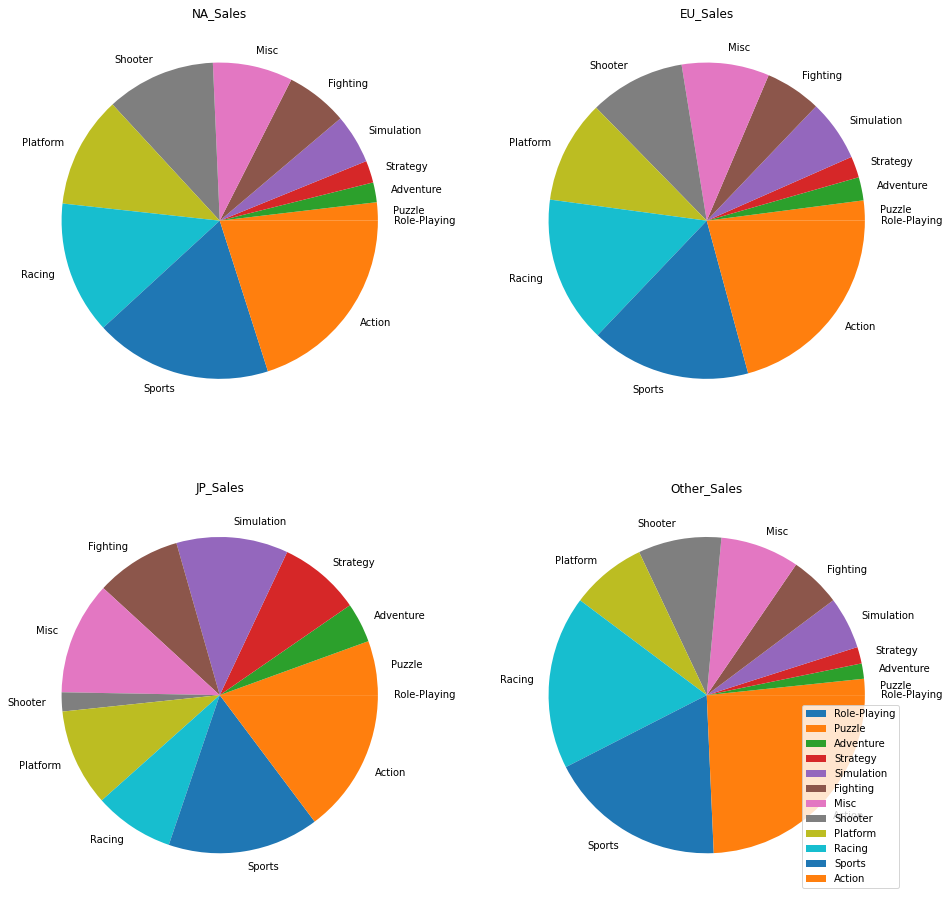

In [ ]:
make_pie(df[df.Genre != 'Role-Playing'], min= 1999, max = 2005)